### INSIGHTS FROM SPANISH ELECTRICITY SYSTEM

The aim of this jupyter notebook is to deep into the data obtained from REE esios platform and from MIBGAS web and review some of the critical aspects of the spanish electricity system such as:
 - Installed capacity and generation mix
 - Electricity price and natural gas price influence
 - Gas adjust mechanism evaluation
 - Future challenges

Time scope of the analysis will be from year 2021 until february 2023, that is the last complete month when this analysis is being performed.

In [2]:
### IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from datetime import datetime,timedelta
import matplotlib.dates as mdates

In [3]:
### INPUTS

input_dir = r"D:\Documentos\Artículos\Análisis energía España\data_sources\01_esios_ree_processed"
output_dir = r"D:\Documentos\Artículos\Análisis energía España\analysis"

In [4]:
### LOAD DATA

power_generation = pd.read_csv(f'{input_dir}\generation_data.csv',index_col='datetime')
power_generation.index = pd.to_datetime(power_generation.index,utc=True).tz_convert('Europe/madrid')

elec_spot_price = pd.read_csv(f'{input_dir}\elec_spot_price.csv',index_col='datetime')
elec_spot_price.index = pd.to_datetime(elec_spot_price.index,utc=True)
elec_spot_price.index = elec_spot_price.index.tz_convert('Europe/madrid')

installed_capacity = pd.read_csv(f'{input_dir}\installed_capacity.csv',index_col='datetime')
installed_capacity.index = pd.to_datetime(installed_capacity.index,utc=True)
installed_capacity.index = installed_capacity.index.tz_convert('Europe/madrid')

gas_price = pd.read_csv(f'{input_dir}\gas_price.csv',index_col='date')

#### INSTALLED CAPACITY

In [5]:
### SOURCE AGGREGATION

agg_dict = {'Carbón':'Coal','Nuclear':'Nuclear','Cogeneración': 'CG','Residuos':'Other',
            'Hidráulica':'Hydro','Solar fotovoltaica': 'Solar','Solar térmica': 'Solar',
            'Eólica': 'Wind','Ciclo combinado': 'CC','Turbinación bombeo': 'Hydro',
            'Otras renovables': 'Other', 'Hidraúlica':'Hydro','Otras':'Other',
            'Turbinación de bombeo': 'Hydro'}

power_generation['agg_source'] = power_generation['source'].apply(lambda x: agg_dict[x])
installed_capacity['agg_source'] = installed_capacity['source'].apply(lambda x: agg_dict[x])

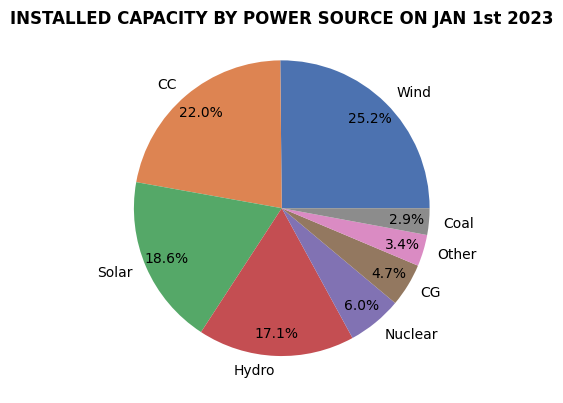

In [6]:
### INSTALLED CAPACITY PLOT

current_capacity = installed_capacity.loc['2023-01-01']\
        .groupby('agg_source').sum(numeric_only=True)\
        .sort_values('capacity',ascending=False)

palette = sns.color_palette('deep')
title = 'INSTALLED CAPACITY BY POWER SOURCE ON JAN 1st 2023'

plt.pie(current_capacity.capacity,
        labels=current_capacity.index,
        colors=palette,
        normalize=True,
        autopct='%.1f%%',
        pctdistance=0.85)
plt.title(f'{title}',fontsize=12,pad=0,y=1,fontweight='bold');

The total installed capacity in Spain by January 1st 2023 was 119.2 GW, being Wind the power source with the most capacity installed with one fourth of this total capacity. It is followed closely by Combined Cycle, Solar and Hydro, entailing this four technologys more than 80 % of the total. Nuclear, Co-generation, Coal and other techonologies add up the rest.

The evolution from 2021 to nowdays can be observed in the following plot. Even though it is not expected to observe huge changes in such a short period of time, some evolution might be infered with Wind and especially Solar gaining importance on the mix while Coal experiences a reduction, showing the Spanish and European goals to de-carbonize electricity generation and reduce carbon emissions. Along with this political will, economic reasons such as cost reduction on renewables and increase carbon price on carbon emission markets may also play a role here.

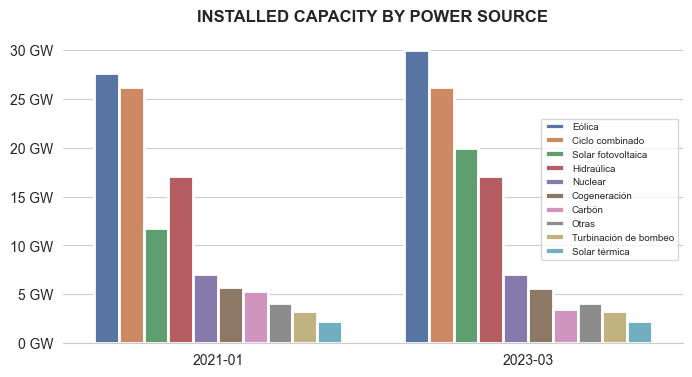

In [7]:
### INSTALLED CAPACITY EVOLUTION

couple_capacity = pd.concat([installed_capacity.loc['2021-01-01'],installed_capacity.loc['2023-03-01']])
couple_capacity['month'] = couple_capacity.index.strftime('%m/%Y')

sns.set_style("whitegrid")
titulo = 'INSTALLED CAPACITY BY POWER SOURCE'
f, ax = plt.subplots(figsize=(8,4));
sns.barplot(
     data=couple_capacity,
     x=couple_capacity.index, 
     y='capacity',
     hue='source',
     hue_order=couple_capacity.sort_values('capacity',ascending=False).source.unique(),
     linewidth=2,
     palette=sns.color_palette('deep'),
     ax=ax
     )

sns.despine(left=True)
ax.legend(loc=7,fontsize=7)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(couple_capacity.index.strftime('%Y-%m').unique())
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:f'{v/1000:,.0f} GW')) # los datos están en MW
ax.set_title('{}'.format(titulo),fontsize=12,fontweight='bold',pad=10,y=1.0);

#### ELECTRICITY GENERATION

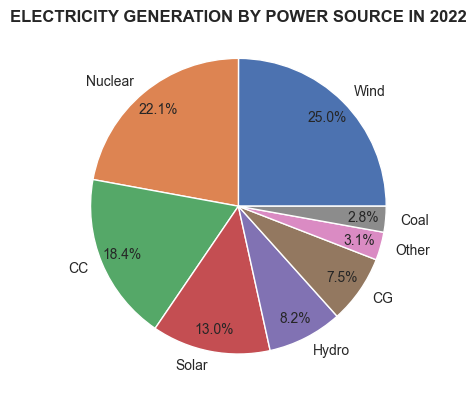

In [8]:
### ELECTRICITY GENERATION DISTRIBUTION BY POWER SOURCE

year = '2022'
yearly_gen = power_generation.groupby('agg_source').resample('Y').sum(numeric_only=True).reset_index().set_index('datetime').sort_values(by='datetime')
yearly_gen['year'] = yearly_gen.index.strftime('%Y')
yearly_gen_pivot = yearly_gen.pivot_table(values='generation',columns='agg_source',index='year')
yearly_pivot_gen_norm = yearly_gen_pivot.div(yearly_gen_pivot.sum(axis=1), axis=0)


titulo = 'ELECTRICITY GENERATION BY POWER SOURCE IN 2022'
palette = sns.color_palette('deep')

plt.pie(yearly_gen[yearly_gen.year==year].sort_values(by='generation',ascending=False).generation,
        labels=yearly_gen[yearly_gen.year==year].sort_values(by='generation',ascending=False).agg_source,
        colors=palette,
        normalize=True,
        autopct='%.1f%%',
        pctdistance=0.85,)
plt.title(f'{titulo}',fontsize=12,pad=0,y=1,fontweight='bold');

Regarding electricity generation, Wind is observed to be as well the power source with the highest share in the generation miz. However, when observing the rest of power sources, the other renewables, Solar and Hydro, are way below when compared to their installed capacity, while CG and especially Nuclear are considerably more important. These variations on generation capacity to installed capacity are explained by the specific characteristics of each technology and their correspondent load factors.

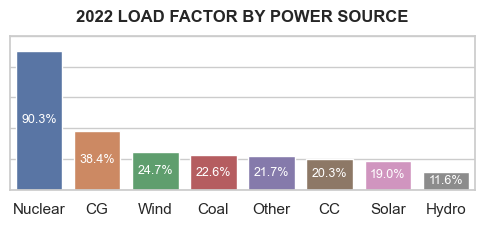

In [9]:
### LOAD FACTOR

# Set the year
year = 2022

# Calculate monthly power generation by source
monthly_gen = power_generation.groupby('agg_source').resample('MS').sum(numeric_only=True)\
    .reset_index().set_index('datetime').sort_values(by='datetime')

# Add a 'month' column to the monthly generation DataFrame
monthly_gen['month'] = monthly_gen.index.strftime('%m')

# Filter the monthly generation DataFrame to only include data from the specified year
monthly_gen = monthly_gen[monthly_gen.index.year==year]\
    .reset_index()\
    .pivot_table(columns='agg_source',index='month',values='generation')

# Calculate monthly installed capacity by source
monthly_capacity = installed_capacity[installed_capacity.index.year==year]\
    .pivot_table(columns='datetime',index='agg_source',values='capacity',aggfunc='sum')

# Calculate the monthly hours for the specified year
monthly_hours = np.array([calendar.monthrange(year, int(month))[1] * 24 \
                          for month in monthly_gen.index.to_list()])

# Calculate the load factor for each power source
gen_array = monthly_gen.sum().to_numpy()
cap_array = monthly_capacity.to_numpy()
load_factor = pd.DataFrame({'source': monthly_capacity.index.to_list(),
                            'load_factor': np.divide(gen_array,(cap_array @ monthly_hours))})

### Plot
sns.set_theme(style='whitegrid')
titulo = f'{year} LOAD FACTOR BY POWER SOURCE'
f, ax = plt.subplots(figsize=(6,2));

sns.barplot(
     data=load_factor.sort_values(by='load_factor',ascending=False),
     x='source', 
     y='load_factor',
     palette=sns.color_palette('deep'),
     ax=ax,
     )

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim([0,1])
ax.bar_label(ax.containers[0], label_type='center',color='white',
             labels=[f'{x.get_height():.1%}' for x in ax.containers[0]],fontsize=9)
ax.set_yticklabels('')
ax.set_title(f'{titulo}',fontsize=12,pad=10,y=1.0,fontweight='bold');

Load factor is an indicator showing the amount of time working at full-capacity which would be equivalent to the total generation in a certain period relative to the hypothetical electricity obtained working at full capacity during the whole period. It is then calculated dividing the total electricity generated divided by the potential electricity generation that would be obtained if all the power plants were working at full capacity, or the equivalent number of hours working at full capacity to produce the electricity generated in a period divided by the total number of hours in such period.

As it was anticipated, Co-generation and especially Nuclear stand on the top two positions, with load factors of 38.4% and 90.3%, whilst Solar and Hydro are at the bottom with 19% and 11.6% respectively. Reasons behind that high load factor in Nuclear is that this technology has a very slow performance curve, which makes it more profitable to have it working at full capacity and selling at cheap price taking into account that its fuel is not too expensive. Co-generation are power plants that uses both the electricity and the heat obtained through combustion, so they are more efficient and are usually related to energy intensive industries and have an interest then in working continously. On the other hand, Solar and Hydro are not able to operate much time, the first due to sunlight hours being limited while the second due to non-infinite water resources. 

Further trends on the different technologies can be infered from the following plot with the average generation curve on a daily basis.

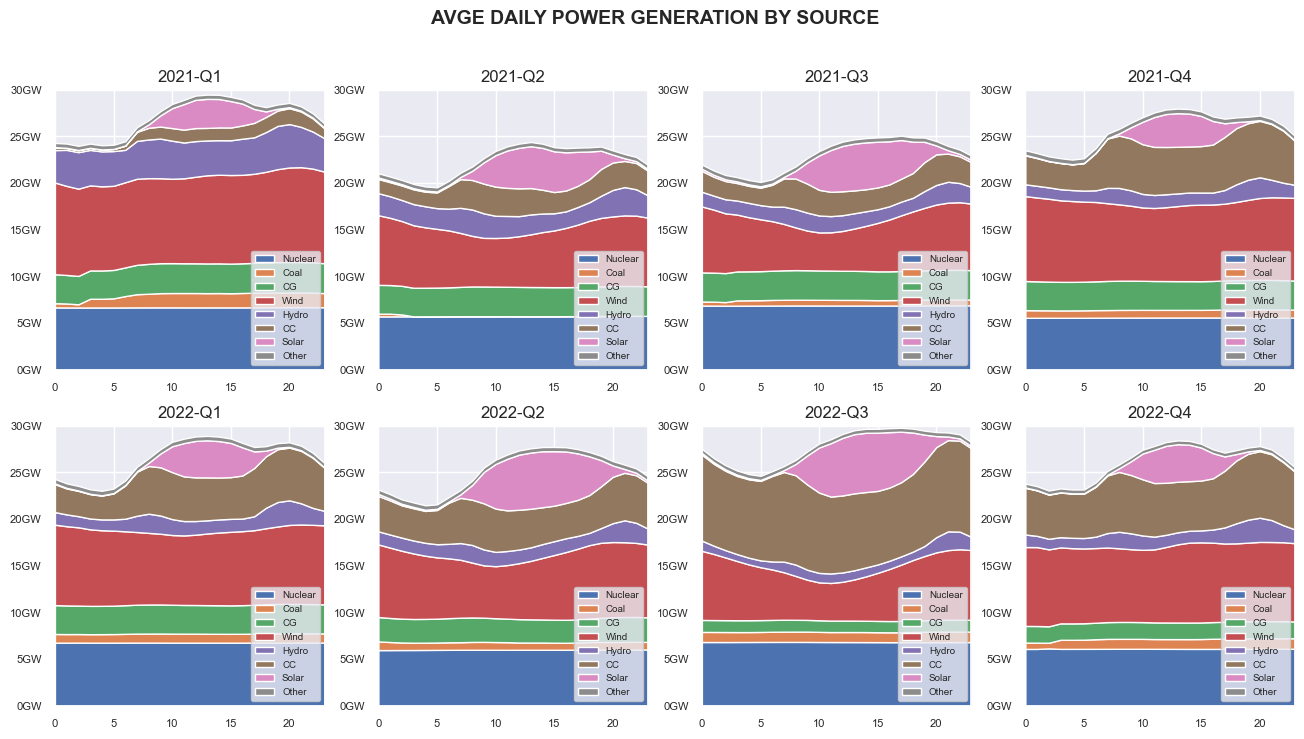

In [10]:
### AVGE DAILY GENERATION BY QUARTER AND POWER SOURCE

# Create a copy of the original DataFrame
quart_gen = power_generation.copy()

# Extract year, quarter and hour from the datetime index
quart_gen['year'] = quart_gen.index.year.astype(str)
quart_gen['quarter'] = quart_gen.index.quarter.astype(str)
quart_gen['hour'] = quart_gen.index.hour

# Group data by year, quarter, hour and agg_source, and calculate mean
quart_gen = quart_gen.groupby(['year', 'quarter', 'hour', 'agg_source'], as_index=False).mean(numeric_only=True)

# Create a new index using the year and quarter columns
quart_gen['period'] = quart_gen['year'] + '-Q' + quart_gen['quarter']
quart_gen = quart_gen.set_index('period')

# Set the seaborn theme and color palette
sns.set_theme()
palette = sns.color_palette('deep')

# Create a figure with 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

# Add a title to the figure
fig.suptitle('AVGE DAILY POWER GENERATION BY SOURCE', fontsize=14,fontweight='bold')

# Loop over each year and quarter
for i, year in enumerate(quart_gen.year.unique()):
    # Skip years after 2022
    if int(year) > 2022:
        continue
    for j, quarter in enumerate(quart_gen.quarter.unique()):
        # Create a string index for the year and quarter
        index = f'{year}-Q{quarter}'
        # Extract the unique hours for the index
        x = quart_gen.loc[index].hour.unique()
        # Extract the power generation data for each source and hour
        y = quart_gen.loc[index].pivot_table(columns='agg_source', index='hour', values='generation').fillna(0) \
            .reindex(columns=['Nuclear', 'Coal', 'CG', 'Wind', 'Hydro', 'CC', 'Solar', 'Other']).values.transpose()
        # Create a stacked area plot for the power generation data
        axs[i, j].stackplot(x, y, colors=palette, labels=['Nuclear', 'Coal', 'CG', 'Wind', 'Hydro', 'CC', 'Solar', 'Other'])
        # Set the plot title and axis labels
        axs[i, j].set_title(f'{index}', fontsize=12)
        axs[i, j].set_xlabel('')
        axs[i, j].set_ylabel('')
        # Add a legend to the plot
        axs[i, j].legend(loc=4, fontsize=7)
        # Format the y-axis ticks to display power generation in GW
        axs[i, j].yaxis.set_major_formatter(plt.FuncFormatter(lambda v, x: f'{v / 1000:.0f}GW'))
        # Set the tick label size
        axs[i, j].tick_params(labelsize=8)
        # Set the x-axis limits to remove the empty space to the left of 0 and to the right of 23
        axs[i, j].set_xlim([0,23])
        axs[i, j].set_ylim([0,30000])


Firstly, it can be observed that Spanish mean generation by quarter oscillates between 20 and 30 GW, with peaks ocurring during most extreme weather conditions either on winter or summer while autumn and mainly spring require less generation. Regarding the shape of the curve, it can be seen that the lower peak occurrs during night hours and the top peaks occur during daylight and often in two phases: morning and evening. 

Analyzing now the influence of each technology:
- Regarding Nuclear, Co-generation and Coal, it can be confirmed what it was anticipating before: their curve is practically horizontal, meaning they work normally at constant capacity. The case of CG, with a reduction occuring from Q2 of 2022 can be observed,  will be commented later.
- With respect to wind, its importance on the mix can be quickly seen. Additionally, it shows particular trends: increased performance during night hours when there is more wind, and slightly reduced during daylight and especcially on summers when there is less of the source. 
- Hydro has a relatively constant hourly share but variable over quarters, since it is highly dependant on water availability to turbine and therefore on rain conditions along the year. Reservoirs are filled normally along the winter and spring and emptied along summer. Q1 of 2021 appears to be the one with highest hydro generation while Q3 of 2022 being the lowest, due to scarcity during this period.
- Regarding solar, it can be clearly observed its dependence on sunlight hours and its higher performance on spring and summer. In addition, it may be curious to see that generation in summer is not that higher than in spring although sunlight conditions are expected to be better. Reason behind this is that when heated too much, solar panels start to being less efficient and do not really benefit from high temperatures.
- Cycle Gas Turbines (CCGT) evolution shows increased importance across these years. Observing its generation volume, two main aspects need to be highlighted. First one is its variability on generation showed along the quarters, being hugely important on Q3 2022 when Wind and especially Hydro role was reduced. Second one is its variability on an hourly basis, as two clear summits can be noticed on morning hours when demand start rising but solar generation is not still avaibable, and on evening hours where demand may also grow, specially on working days, and solar is retiring from the system. These aspects can also be observed in Hydro power source and makes these two technologies critical for electricity prices as it will be seen next.

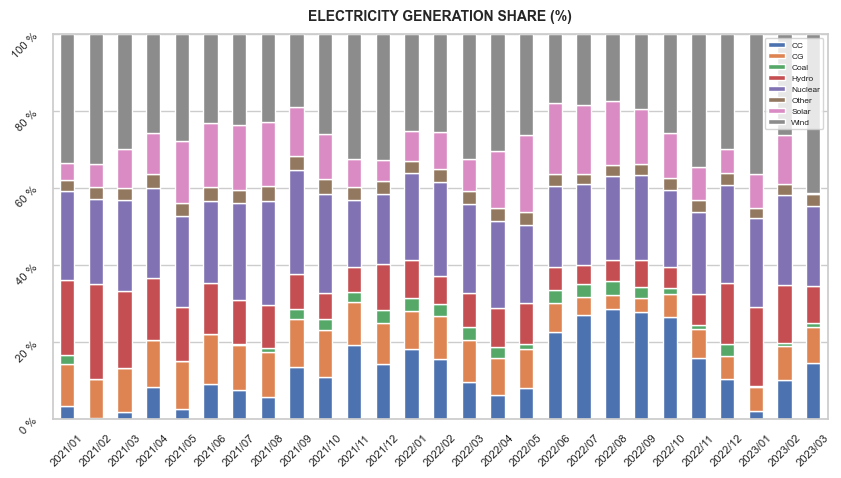

In [11]:
### MONTHLY ELECTRICITY GENERATION SHARE BY POWER SOURCE

monthly_gen = power_generation.groupby('agg_source').resample('MS').sum(numeric_only=True).reset_index().set_index('datetime').sort_values(by='datetime')
monthly_gen['date'] = monthly_gen.index.strftime('%Y/%m')
monthly_pivot_gen = monthly_gen.pivot_table(values='generation',columns='agg_source',index='date')
monthly_pivot_gen_norm = monthly_pivot_gen.div(monthly_pivot_gen.sum(axis=1), axis=0)

sns.set_style("whitegrid")
titulo = 'ELECTRICITY GENERATION SHARE (%)'
palette = sns.color_palette('deep')

ax = monthly_pivot_gen_norm.plot.bar(stacked=True,
                                     figsize=(10,5))
ax.legend(loc='upper right',fontsize=6)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(top=1)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:f'{v*100:.0f} %'))
ax.set_xticklabels(monthly_pivot_gen_norm.index)
ax.tick_params(axis='both',rotation=45,labelsize=8)
ax.set_title('{}'.format(titulo),fontsize=10,pad=10,y=1.0,fontweight='bold');

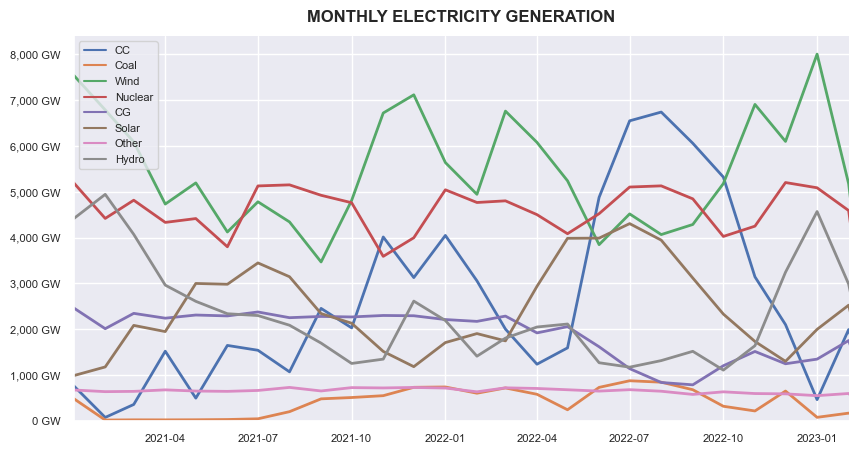

In [12]:
### MONTHLY ELECTRICITY GENERATION BY POWER SOURE

sns.set_style("darkgrid")
titulo = 'MONTHLY ELECTRICITY GENERATION'
f, ax = plt.subplots(figsize=(10,5));
sns.lineplot(
     data=monthly_gen,
     x='datetime', 
     y='generation',
     estimator=sum,
     hue='agg_source',
     linewidth=2,
     color=sns.color_palette('deep'),
     ax=ax
     )

sns.despine()
ax.legend(loc='upper left',fontsize=8)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xlim([pd.Timestamp('2021-01-01'), pd.Timestamp('2023-02-01')])
ax.set_ylim(bottom=0)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:f'{v/1000:,.0f} GW'))
ax.tick_params(axis='both',labelsize=8)
ax.set_title('{}'.format(titulo),fontsize=12,pad=10,y=1.0,fontweight='bold');

#### ELECTRICITY PRICE

In European electricity markets, price is set throughout auction and marginal system. Demanding and producing agents make their bids to buy or sell energy at a certain price, and those bids are matched from lower prices to higher until the predicted demand is satisfied. Marginality comes into place since the price matching the last slots of generation-demand, that is the highest price in the auction, becomes the price by which all the electricity is rewarded independently of their own bids.

Combined Cycle and Hydro, as it was previously noticed, have the capacity to modify their operation range in a quick pace and are dispatchable, that is, their generation is not dependant weather condicitions and decisions on when to produce can be taken. These properties make them ideal to adapt to the rapid changes in demand and therefore have the key to drive the price, since they are usually the ones closing the auction and setting the price.

Evolution of electricity prices in some of the european markets are shown next.

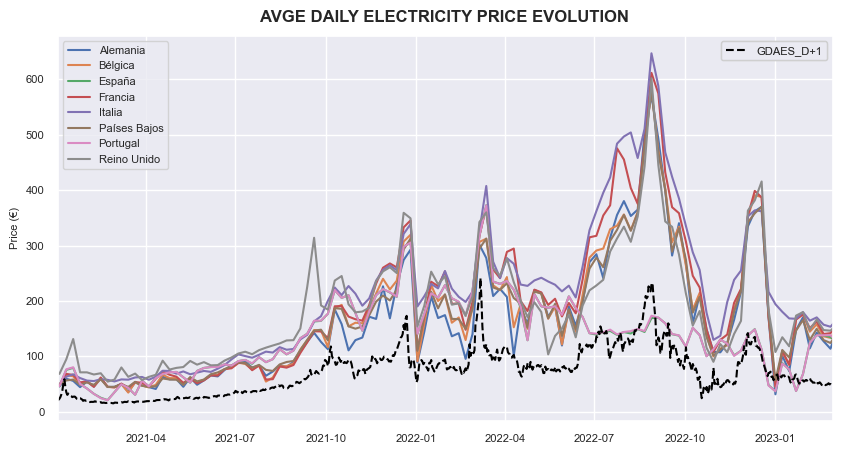

In [139]:
### ELECTRICITY AND GAS PRICE EVOLUTION

# Daily electricity price shown here is just the arithmetic mean of the hourly prices, not weighted by the generation.

country_filter = False
gas_comparison = True
country ='España'

daily_price = elec_spot_price.groupby('country').resample('W').mean(numeric_only=True).reset_index()
if country_filter:
    daily_price = daily_price[daily_price.country==country]

sns.set_style("darkgrid")
titulo = 'AVGE DAILY ELECTRICITY PRICE EVOLUTION'
f, ax = plt.subplots(figsize=(10,5));
sns.lineplot(
     data=daily_price,
     x='datetime', 
     y='price',
     hue='country',
     estimator=sum,
     color=sns.color_palette('deep'),
     linewidth=1.5,
     ax=ax)

if gas_comparison:
        ax.plot(pd.to_datetime(gas_price[gas_price.indicator=='GDAES_D+1'].index),
                gas_price[gas_price.indicator=='GDAES_D+1'].price,
                linestyle='--',
                label='GDAES_D+1',
                color='black',
                linewidth=1.5)

handles, labels = ax.get_legend_handles_labels()
electricity_legend = ax.legend(handles[:len(handles)-1],labels[:len(labels)-1], loc='upper left', fontsize=8)
ax.add_artist(electricity_legend)
if gas_comparison:
    gas_legend = ax.legend(handles=[handles[-1]], labels=[labels[-1]], loc='upper right', fontsize=8)
    ax.add_artist(gas_legend)

ax.set_xlabel('')
ax.set_ylabel('Price (€)',fontsize=8)
ax.set_title('{}'.format(titulo),fontsize=12,pad=10,y=1.0,fontweight='bold')
ax.tick_params(axis='both',labelsize=8)
ax.set_xlim([pd.Timestamp('2021-01-01'), pd.Timestamp('2023-02-28')]);

In the past two years electricity prices have escalated real quick with rising start in the last months of 2021 and peaking in August 2022 for most of the countries but Spain and Portugal.

Gas prices plotted is the the price on the day-ahead futures market of the Iberian Market of Gas (MIBGAS). Correlation with electricity price is clearly shown during these couple of years, with the exception again in the Iberian Peninsula from June 2022 with a clear deviation from the gas price. On June 15th, a law aimed to specifically de-coupled gas prices to electricity prices (RD 10/2022) started functioning for the Iberian Peninsula, with evident result. Further analysis on this topic is performed later in this notebook.

Influence of natural gas is clear, but let see now analyze the influence of each power source on prices. For that, the share of each power source is plotted against the price on a weekly basis.

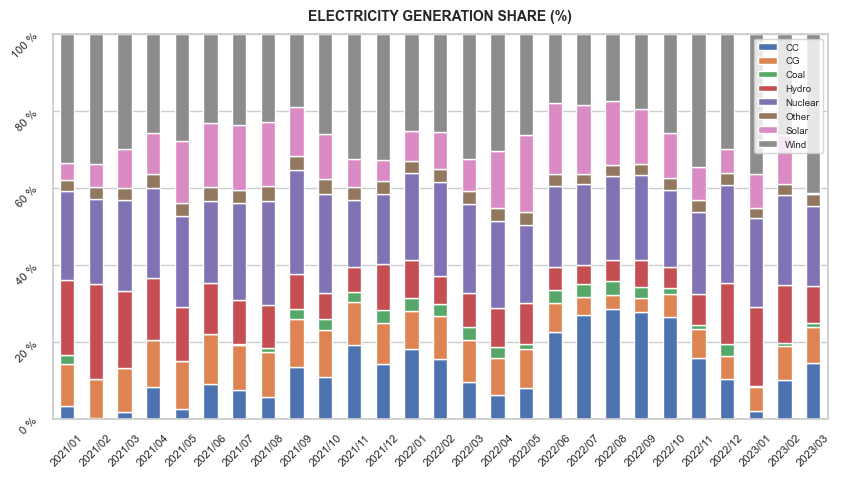

In [332]:
### MONTHLY ELECTRICITY GENERATION SHARE BY POWER SOURCE

monthly_gen = power_generation.groupby('agg_source').resample('MS').sum(numeric_only=True).reset_index().set_index('datetime').sort_values(by='datetime')
monthly_gen['date'] = monthly_gen.index.strftime('%Y/%m')
monthly_pivot_gen = monthly_gen.pivot_table(values='generation',columns='agg_source',index='date')
monthly_pivot_gen_norm = monthly_pivot_gen.div(monthly_pivot_gen.sum(axis=1), axis=0)

sns.set_style("whitegrid")
titulo = 'ELECTRICITY GENERATION SHARE (%)'
palette = sns.color_palette('deep')

ax = monthly_pivot_gen_norm.plot.bar(stacked=True,
                                     figsize=(10,5))
ax.legend(loc='upper right',fontsize=7)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(top=1)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:f'{v*100:.0f} %'))
ax.set_xticklabels(monthly_pivot_gen_norm.index)
ax.tick_params(axis='both',rotation=45,labelsize=8)
ax.set_title('{}'.format(titulo),fontsize=10,pad=10,y=1.0,fontweight='bold');

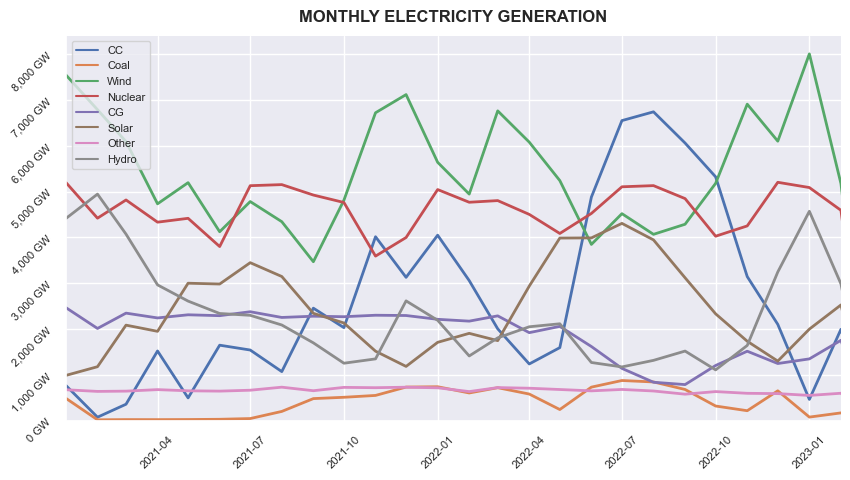

In [15]:
### MONTHLY ELECTRICITY GENERATION BY POWER SOURE

sns.set_style("darkgrid")
titulo = 'MONTHLY ELECTRICITY GENERATION'
f, ax = plt.subplots(figsize=(10,5));
sns.lineplot(
     data=monthly_gen,
     x='datetime', 
     y='generation',
     estimator=sum,
     hue='agg_source',
     linewidth=2,
     color=sns.color_palette('deep'),
     ax=ax
     )

sns.despine()
ax.legend(loc='upper left',fontsize=8)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xlim([pd.Timestamp('2021-01-01'), pd.Timestamp('2023-02-01')])
ax.set_ylim(bottom=0)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:f'{v/1000:,.0f} GW'))
ax.tick_params(axis='both',rotation=45,labelsize=8)
ax.set_title('{}'.format(titulo),fontsize=12,pad=10,y=1.0,fontweight='bold');

When comparing the price evolution in Spain with the generation mix each month both absolute and relative, the mentioned influence of CC and therefore natural gas is clearly observed before June 2022. As the CC gains importance on the mix by the end of 2021 together with rising in natural gas prices themselves (caused probably by the first), prices rose as well. March peak of natural gas price was not directly caused by its use on electricity but for the influence of the Ukraine War and its impact on international markets of natural gas, where demand increased greatly fearing lack of natural gas for the next winter if Russian Gas were not be available. On summer 2022, prices skyrocketed across Europe with the mentioned exception in the Iberian Peninsula, as the need to use CC due to the worst drought in many years was added to the continued instability on gas markets. Finally, on the recent months and caused mainly by the wheather conditions: on one hand the mild winter reduced the demand of natural gas and on the other hand the rainy autumn and winter increased the share hydro and which together with wind entailed a great share of the production. 

When focusing on each power source share individual correlation with the electricity price, some additional insights can be obtained:

In [124]:
### CALCULATE HOURLY AND DAILY ELECTRICITY PRICE AND SHARES

end_date = '2023-03-01'

spain_price = elec_spot_price[(elec_spot_price.country=='España') & (elec_spot_price.index<end_date) ].drop(['country'],axis=1)
spain_price['generation'] = power_generation.resample('H').sum(numeric_only=True)
spain_price['cost'] = spain_price.price * spain_price.generation

spain_price_daily = spain_price.resample('D').sum()
spain_price_daily = spain_price_daily[spain_price_daily.index<end_date]
spain_price_daily['price'] = spain_price_daily.cost / spain_price_daily.generation

spain_generation = power_generation.pivot_table(columns='agg_source',index='datetime',values='generation').fillna(0)
spain_generation_norm=spain_generation.div(spain_generation.sum(axis=1), axis=0)[spain_generation.index<end_date]
spain_daily_generation = spain_generation.resample('D').sum(numeric_only=True)
spain_daily_generation_norm=spain_daily_generation.div(spain_daily_generation.sum(axis=1), axis=0)[spain_daily_generation.index<end_date]

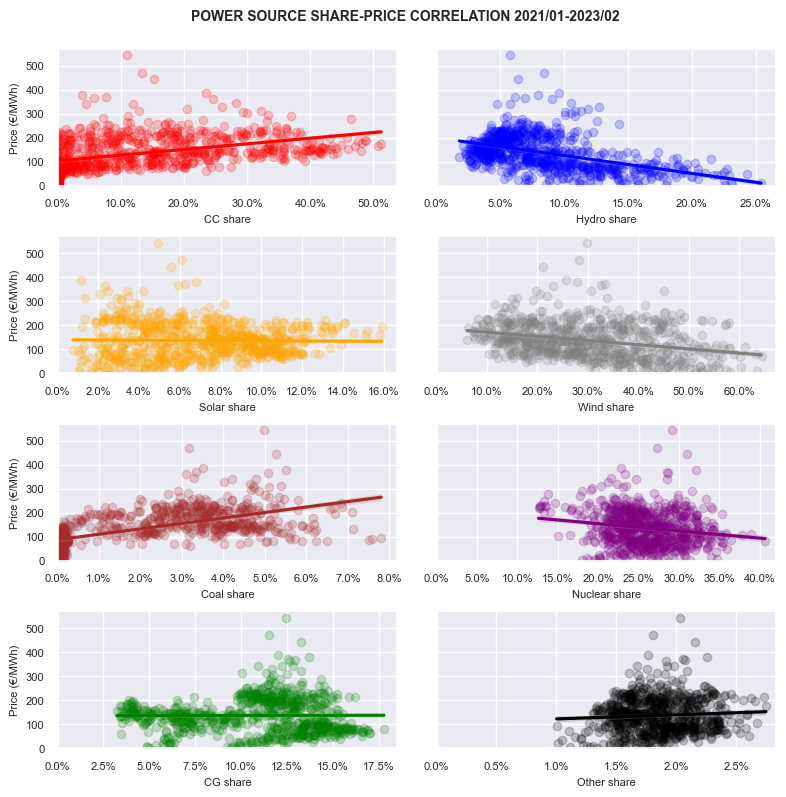

In [118]:
### CORRELATION BETWEEN POWER SOURCE SHARE IN GENERATION AND PRICE

# Set power sources to analyse
power_sources = {'CC':[[0,0],'red'],
                 'Hydro':[[0,1],'blue'],
                 'Solar':[[1,0],'orange'],
                 'Wind':[[1,1],'grey'],
                 'Coal':[[2,0],'brown'],
                 'Nuclear':[[2,1],'purple'],
                 'CG':[[3,0],'green'],
                 'Other':[[3,1],'black']}

# Create a figure with 2 rows and 4 columns
sns.set_theme()
palette = sns.color_palette('deep')
fig, axs = plt.subplots(4, 2, figsize=(8, 8),squeeze=False,sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.4)

# Add a title to the figure
fig.suptitle('POWER SOURCE SHARE-PRICE CORRELATION 2021/01-2023/02', fontsize=10,fontweight='bold')
fig.tight_layout();

# Scatter plots
y=spain_price_daily.price

for n, source in enumerate(power_sources.keys()):
    i,j = power_sources[source][0]
    color = power_sources[source][1]
    x=spain_daily_generation_norm[source]
    sns.regplot(x=spain_daily_generation_norm[source],
                    y=spain_price_daily.price,
                    scatter_kws={'alpha':.2},
                    color=color,
                    ax=axs[i,j]);
    
    axs[i,j].set_xlabel(f'{source} share',fontsize=8)
    if j==0:
        axs[i,j].set_ylabel('Price (€/MWh)',fontsize=8)
    else:
        axs[i,j].set_ylabel('')
    axs[i,j].xaxis.set_major_formatter(plt.FuncFormatter(lambda v, x: f'{v*100:.1f}%'))
    axs[i, j].set_xlim(left=0)
    axs[i, j].set_ylim(bottom=0)
    axs[i,j].tick_params(axis='both',labelsize=8)

- A clear positive correlation between prices and Combined Cycle and Coal shares, as well as an inverse correlation with Hydro, Wind and Nuclear. Solar appears to be neutral. 
- Combined cycle capacity to change operation degree along with the specific cost of natural gas fuel seems to be the reasons behind its direct relation to electricity prices. 
- Nuclear inverse correlation can be explained by its low variable costs and slow performance curve, which, even though it is a dispatchable technology, limits its capacity to do 'market timing'. Therefore, as it operates almost continuosly at full capacity, its share is higher when demand is lower, which is also when it is more probable for the price to be lower.
- Similarly to Nuclear occurs to Coal, since its performance curve is also slow. Nevertheless, regarding price, it is more similar to gas since fuel price is also high, not because its extraction and transport costs but due to the carbon rights emissions mentioned before.
- Wind inverse correlation can be explained by its non-dispatchable or intermittency characteristic. Along with Solar, these renewable power sources do not have a fuel variable cost so and benefit from selling all the electricity being produced independtly of the price since there is yet no profitable technology to store the electricity it at big scale, neither the source of course. Therefore, when resource is available, bid offers to sell electricity coming from Solar and Wind are expected to be 0, driving the price down when their combined shares are higher. However, in the case of Solar individually, no clear inverse correlation is shown in the chart due to the fact that the analysis is being perfomed weekly rather than hourly. From the next graph it can be clearly concluded the solar drives down the price when entering the mix, considering that demand is higher during the day as we have seen before.
- Regarding hydro, similar characteristics to CCGT mentioned before could be expected, which would make it also a direct price driver. Nevertheless, there are some other aspects to keep in mind related to hydro that make it different. First, not all hydro is dispatchable. River-flow hydro just turbines water flowing without storing it. Second, there are certain ecologic flows that need to be maintained. Finally, water-storage is non-infinite, as nor are the water reservoirs. These aspects are limitations imposed to free decision of when to produce electricity, which could explain the inverse relation and hydro power plants need to address them when deciding when to produce electricity to optimize revenue, making this power source a more of a 'price follower' rather than a 'price driver'.

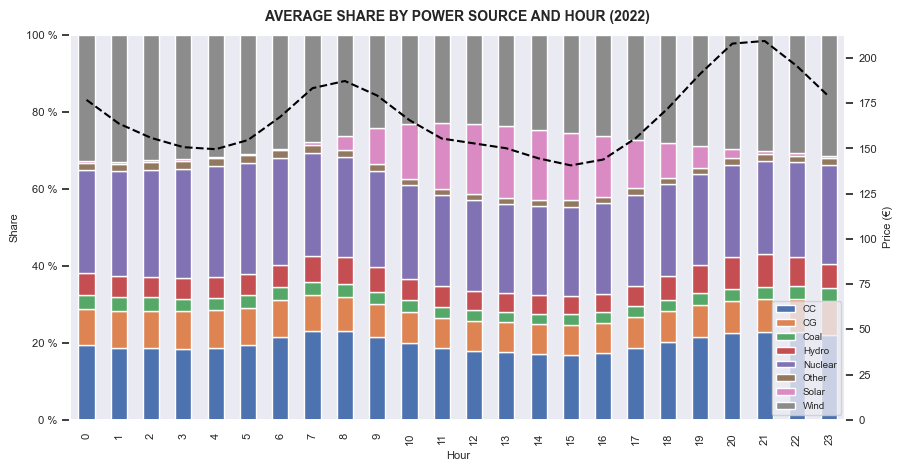

In [119]:
### AVERAGE SHARE BY HOUR

hourly_price = pd.merge(spain_price,spain_generation_norm,on='datetime')

init_date = '2022-01-01'
end_date = '2022-12-31'

average_share = hourly_price[(hourly_price.index>=init_date) & (hourly_price.index<=end_date)]
average_share = average_share.groupby(average_share.index.hour).mean()

sns.set_style("darkgrid")
titulo = 'AVERAGE SHARE BY POWER SOURCE AND HOUR (2022)'
palette = sns.color_palette('deep')

'''fig, ax = plt.subplots(figsize=(8, 4))
ax.stackplot(average_share.index,
             average_share.iloc[:,3:].reindex(columns=['Nuclear', 'Coal', 'CG', 'Wind', 'Hydro', 'CC', 'Solar', 'Other']).values.transpose(),
             colors=palette,
             labels=['Nuclear', 'Coal', 'CG', 'Wind', 'Hydro', 'CC', 'Solar', 'Other'])'''

ax = average_share.iloc[:,3:].plot.bar(stacked=True,figsize=(10,5))
ax.grid(False)
ax.legend(loc='lower right',fontsize=7)
ax.set_xlabel('Hour',fontsize=8)
ax.set_ylabel('Share',fontsize=8)
ax.set_ylim(top=1)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:f'{v*100:.0f} %'))
ax.tick_params(axis='both',labelsize=8)
ax.set_title('{}'.format(titulo),fontsize=10,pad=10,y=1.0,fontweight='bold');

ax2=ax.twinx()
ax2.grid(False)
ax2.plot(average_share.index,average_share.price,
         linestyle='--',
         label='GDAES_D+1',
         color='black',
         linewidth=1.5)
ax2.set_ylabel('Price (€)',fontsize=8)
ax2.set_ylim(bottom=0)
ax2.tick_params(axis='y',labelsize=8);

#### GAS ADJUST MECHANISM

The temporal gas adjust mechanism consists in compensating those technologies dependant on the gas price. That is mainly CCGT but also Coal and Co-Generation since Coal price have been correlating with gas prices during these months as some of the forwards contracts for coal are indexed to gas prices. The amount of the compensation is set on the RD 10/2022 and is calculated the following way. 

Compensation = (PGN-PRGN)/0.55 €/MWh

PGN (Gas Natural Price) is published by MIBGAS on a daily basis for the day ahead. PRGN (Gas Natural Regulated Price) is the cap price set by the administration, which is 40 €/MWh for the first 6 months and then rising 5€/MWh every month for another 6 months. The regulation lasts for a year, therefore ending on June 2023. Finally, the 0.55 adjustment is set to transform the gas natural cost to the electricity cost generated from it. It can be observed in the next graph, observing the period before June 2022, that applying this coefficient gas and electricity prices match considerably. 

In [120]:
### SET DAILY SPAIN PRICE

spain_price = elec_spot_price[(elec_spot_price.country=='España') & (elec_spot_price.index<end_date) ]\
    .drop(['country'],axis=1)
spain_price['generation'] = power_generation.resample('H').sum(numeric_only=True)
spain_price['cost'] = spain_price.price * spain_price.generation
spain_price = spain_price.resample('D').sum()
spain_price = spain_price[spain_price.index<end_date]
spain_price['price'] = spain_price.cost / spain_price.generation

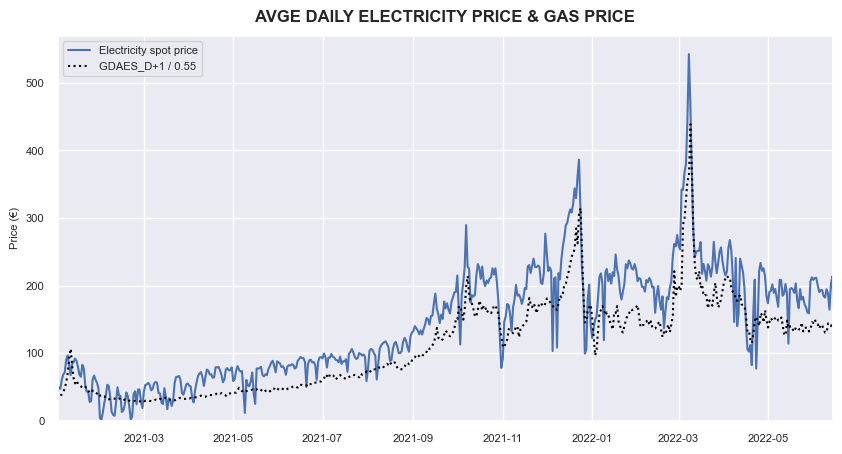

In [121]:
### GAS / 0.55 vs. ELECTRICITY

sns.set_style("darkgrid")
titulo = 'AVGE DAILY ELECTRICITY PRICE & GAS PRICE'
f, ax = plt.subplots(figsize=(10,5));

ax.plot(spain_price.index, 
        spain_price.price,
        label='Electricity spot price',
        linewidth=1.5)

ax.plot(pd.to_datetime(gas_price[(gas_price.indicator=='GDAES_D+1')].index) + timedelta(days=2),
        gas_price[(gas_price.indicator=='GDAES_D+1')].price / 0.55,
        linestyle='dotted',
        label='GDAES_D+1 / 0.55',
        color='black',
        linewidth=1.5)

ax.legend(loc='upper left',fontsize=8)
ax.set_xlabel('')
ax.set_ylabel('Price (€)',fontsize=8)
ax.set_title('{}'.format(titulo),fontsize=12,pad=10,y=1.0,fontweight='bold')
ax.set_xlim([pd.Timestamp('2021-01-01'), pd.Timestamp('2022-06-14')])
ax.tick_params(axis='both',labelsize=8)
ax.set_ylim(bottom=0);

This way, when electricity producers from these technologies make their sell bids on the auctions, they internalize this compensation when setting the bid leading then to a reduction in the price. It has been discussed by the general public and some political sectors whether this mechanism is working effectively and driving down the electricity cost or if it is just a deviation or a subside mechanism and no cost reduction is achieved. Let's give light to this debate. 

For that, both the compensation cost from the adjust mechanism and the saved cost derived have been calculated. The compensation cost is obtained just by multiplying the compensation rate in €/MWh to the total amount of electricity generated by CCGT, CG and Coal. It is important to highlight here that whenever natural gas price is lower to the regulated price, adjust mechanisms does not apply that day nor an inverse compensation to the government is requested.

Saved cost calculation is not trivial, hypotheses need to be taken since without the adjust mechanism sell bids for electricity generated by these power sources would have been different, so just inference can be made. The approach taken here is to suppose that all the power sources are compensated equally, so considering that (i) compensable power sources get always to set the marginal price and (ii) that the compensation is completely accurate and the total amount of money received by those power sources equals the hypothical revenue if the mechanism were not functioning. 

The following graph shows the electricity spot cost, the adjust mechanism cost and the hypothetical saved cost, revealing that there is indeed a saving in electricity cost and therefore an electricity price reduction.

In [134]:
## GAS PRICE CAP & ADJUST COST

pgn_price = gas_price[gas_price.indicator=="PGN"]
date_filter = (pgn_price.index>'2023-01-31')
pgn_price.loc[:,'adjust_cost'] = 0
pgn_price.loc[date_filter,'adjust_cost'] = (pgn_price.loc[date_filter,'price'] -45) / 0.55
pgn_price.loc[~date_filter,'adjust_cost'] = (pgn_price.loc[~date_filter,'price'] -40) / 0.55
pgn_price.loc[pgn_price['adjust_cost'] < 0,'adjust_cost'] = 0

adjust_generation = power_generation[power_generation['agg_source'].isin(['CC', 'CG', 'Coal'])]\
     .resample('D').sum(numeric_only=True)
adjust_generation.index = adjust_generation.index.strftime('%Y-%m-%d')
adjust_generation.rename(columns={'generation':'generation_to_adjust'},inplace=True)
adjust_generation['generation_rest'] = power_generation[~power_generation['agg_source'].isin(['CC', 'CG', 'Coal'])]\
     .resample('D').sum(numeric_only=True)

pgn_price = pgn_price.join(adjust_generation)
pgn_price['total_adjust']=pgn_price['adjust_cost'] * pgn_price['generation_to_adjust']
pgn_price['saved_cost'] = pgn_price['adjust_cost'] * pgn_price['generation_rest']
pgn_price['spot_cost'] = spain_price_daily.cost

pgn_price.index = pd.to_datetime(pgn_price.index)

C:\Users\mario\AppData\Local\Temp\ipykernel_14592\3563896686.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pgn_price.loc[:,'adjust_cost'] = 0


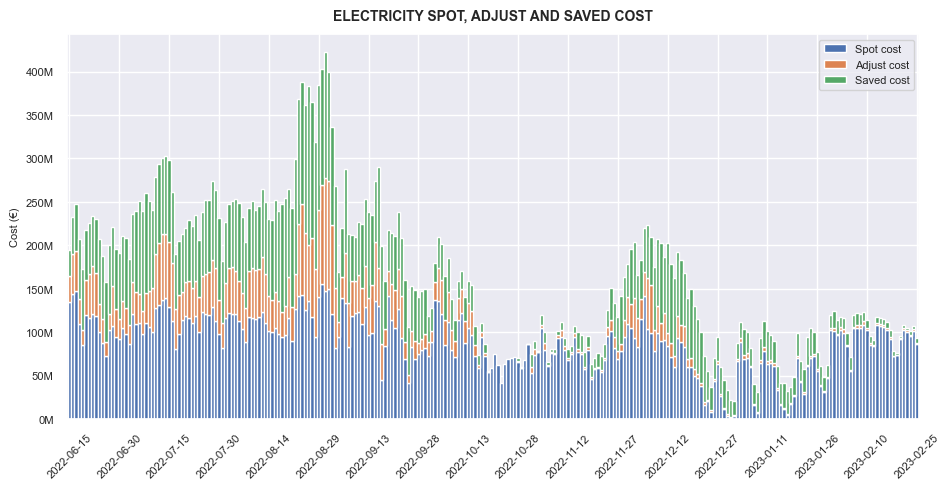

In [135]:
### ELECTRICITY SPOT, ADJUST AND SAVED COSTS

title = 'ELECTRICITY SPOT, ADJUST AND SAVED COST'
ax = pgn_price[['spot_cost','total_adjust','saved_cost']]\
    .plot.bar(stacked=True,figsize=(11,5),width=1)

# Set x-tick frequency and date format
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax.legend(loc='upper right',fontsize=8,labels=['Spot cost','Adjust cost','Saved cost'])
ax.set_xlabel('')
ax.set_ylabel('Cost (€)',fontsize=8)
ax.set_ylim(bottom=0)
ax.set_xticks(range(0, len(pgn_price), 15))
ax.set_xticklabels(pgn_price.index.strftime('%Y-%m-%d')[::15],rotation=45)
ax.tick_params(axis='both',labelsize=10)
ax.yaxis.set_major_formatter((plt.FuncFormatter(lambda v, x: f'{v / 1000000:.0f}M')))
ax.tick_params(axis='both',labelsize=8)
ax.set_title('{}'.format(title),fontsize=10,pad=10,y=1.0,fontweight='bold');

In [96]:
### SAVING STATS

total_saved = pgn_price.saved_cost.sum()
daily_saved = pgn_price.saved_cost.mean()
total_saved_relative = total_saved / pgn_price[['spot_cost','total_adjust','saved_cost']].sum().sum()

print(f'A total {total_saved/1000000:,.2f} M€ were saved due to the introduction of the adjust mechanism, resulting in a {total_saved_relative*100:.1f}% cost reduction.\n')

applied_price = pgn_price.eval('(spot_cost + total_adjust) / (generation_to_adjust + generation_rest)').mean()
hypothetical_price = pgn_price.eval('(spot_cost + total_adjust + saved_cost) / (generation_to_adjust + generation_rest)').mean()

print(f'Applied price including adjust cost was on average {applied_price:,.2f} €, while hypothetical price would have been {hypothetical_price:,.2f} € resulting in a {(1-applied_price/hypothetical_price)*100:.1f}% daily average price reduction.\n')

A total 12,901.96 M€ were saved due to the introduction of the adjust mechanism, resulting in a 33.9% cost reduction.

Applied price including adjust cost was on average 172.71 €, while hypothetical price would have been 254.35 € resulting in a 32.1% daily average price reduction.



A total 12,901.96 M€ is estimated to be saved between June 15th 2022 and February 25th 2023 due to the introduction of the adjust mechanism, resulting in a 33.9% cost reduction. Applied price including adjust cost was on average 172.71 €, while hypothetical price would have been 254.35 € resulting in a 32.1% daily average price reduction.

When observing the hypothetical prices adding up these costs to the spot market, additional trends are visible.

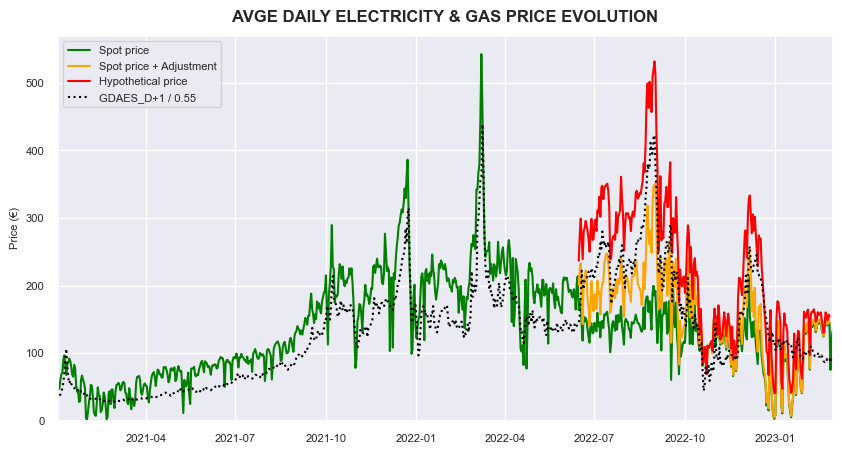

In [138]:
### PRICE COMPARISONS

hypothetical_price = pgn_price.eval('(spot_cost + total_adjust + saved_cost) / (generation_to_adjust + generation_rest)')
adjust_price = pgn_price.eval('(spot_cost + total_adjust) / (generation_to_adjust + generation_rest)')

sns.set_style("darkgrid")
titulo = 'AVGE DAILY ELECTRICITY & GAS PRICE EVOLUTION'
f, ax = plt.subplots(figsize=(10,5));

ax.plot(spain_price_daily.index, 
        spain_price_daily.price,
        label='Spot price',
        color='green',
        linewidth=1.5)

ax.plot(pgn_price.index, 
        adjust_price,
        linestyle='-',
        label='Spot price + Adjustment',
        color='orange',
        linewidth=1.5)

ax.plot(pgn_price.index,
        hypothetical_price,
        linestyle='-',
        label='Hypothetical price',
        color='red',
        linewidth=1.5)

ax.plot(pd.to_datetime(gas_price[(gas_price.indicator=='GDAES_D+1')].index) + timedelta(days=2),
        gas_price[(gas_price.indicator=='GDAES_D+1')].price / 0.55,
        linestyle='dotted',
        label='GDAES_D+1 / 0.55',
        color='black',
        linewidth=1.5)

ax.legend(loc='upper left',fontsize=8)
ax.set_xlabel('')
ax.set_ylabel('Price (€)',fontsize=8)
ax.set_title('{}'.format(titulo),fontsize=12,pad=10,y=1.0,fontweight='bold')
ax.set_xlim([pd.Timestamp('2021-01-01'), pd.Timestamp('2023-02-28')])
ax.tick_params(axis='both',labelsize=8)
ax.set_ylim(bottom=0);

Hypothetical price calculated here seems to be reasonable compared with previous spot price and gas price evolutions, correlating clearly with the latter and maintaned above it. Focusing on the period after the adjust mechanism was introduced, it can be noticed that spot price ceases that correlation with gas price.

When looking the other two linesplots, it may be observed that correlation between both and the gas price, but also that the gap distance to the gas price is not maintaned through time. It is in fact this gap, the area between these two trends, which represents the cost savings in electricity. The reason why it is variable is because, as it has been anticipated, the share of electricity generated by each power source have also a considerable influence on the price, with nuclear, hydro or wind driving it down whilst Combined Cycle or Coal driving it up. The highest the share of the latter, the higher the price to be compensated but the lower the relative savings. While the lowest the share of gas related power sources, the lower the price and the higher the savings, cause a larger share of the electricity is not compensated, which seems reasonable since they are non-dependent on gas prices.

Finally, it can be observed that when gas price goes near 75 €/MWh (40 or 45 /0.55), the three lines merge since compensation is not applied.

#### CONCLUSIONS

It is broadly agreed that electricity is a key element for the economy, influencing directly the production of goods and the service sector. Having analyzed the different power sources, how the electricity market functions and the reason behind the recent increases in electricity prices, somes questions and challenges may arise:
- Whether it is reasonable that the marginal price is applied to all the power sources independently of their nature. It is true that marginality helps allocate scarce resources, as it may be for instance hydro reservoir, to the periods or specific time slots when they are needed the most, but power sources such as solar, wind, nuclear or hydro itself have reduced variable costs which conflicts with electricity produced from them being sold at a high price. Although they do not depend absolutely on gas, they have been benefitting from their skyrocketted prices and producers have increased their margins due to this crisis.
- Whether the current evolution of the spanish electric system is viable. Renewable sources, mainly wind and solar, have been supported aiming to reach the carbon emissions targets set by the european regulation. Nevertheless, it seems clear that natural gas is key for the system to adapt to the intermitent nature of these technologies. In addition, spanish nuclear power plants are considerably old and it is discussed wheter to increase their lifetime. 

Future analysis on these topics may result interesting. Actually, electricity market reform is being discussed currently for the European Union, gaining importance due to the recent escalation in electricity prices in particular and its repercusion on inflation. It would be interesting to analyze the impact of the new regulation to be approved on the electricity markets.